# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, local_earthquake_quicklook, data_wrangler, haversine
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance
from obspy.taup import TauPyModel
import math

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [2]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,7,0,0),
                minmagnitude=3,
                maxradiuskm=600, 
                latitude=47.60,
                longitude=-122.33)

print("Returned %s events" % len(events))
 
 

Returned 28 events


### Choose an event to analyze

In [3]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df


#event_df.iloc[0::]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
27,us7000j3g5,2022-12-28 08:07:48.265,off the coast of Washington,47.840200,-128.923300,12.086,3.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,234
26,us7000j3f8,2022-12-28 08:06:54.980,"267 km SW of Tofino, Canada",47.804700,-128.908400,9.158,3.80,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,222
25,us7000ishe,2022-11-26 03:50:17.526,"18 km NW of Tofino, Canada",49.271400,-126.092300,33.380,4.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,527
24,us7000iqsk,2022-11-18 15:42:45.032,off the coast of Oregon,43.374100,-126.635600,10.000,4.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,298
23,us7000imha,2022-11-04 14:16:58.043,Off the coast of Oregon,43.401300,-127.099500,10.000,3.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,178
22,us7000im59,2022-11-03 09:57:33.841,Off the coast of Oregon,43.327300,-126.840700,10.000,3.50,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,189
21,us7000ikhh,2022-10-26 15:18:19.752,"169 km W of Langlois, Oregon",43.173500,-126.500500,10.000,3.20,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,158
20,us6000itsl,2022-10-14 21:23:02.037,"152 km WNW of Port Orford, Oregon",43.070100,-126.307200,10.000,3.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,168
19,uw61886506,2022-10-07 12:52:36.010,"16 km ESE of Lacomb, Oregon",44.540333,-122.550833,13.170,4.39,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,896
18,us6000ipd3,2022-09-29 15:09:32.565,off the coast of Washington,47.637400,-128.921800,10.555,3.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,168


In [4]:
#just save 600 km (3 to 5 mw earthquakes)
dist_kmarray = []
magnituddarray = []


In [ ]:
#just save between 700 and 600km (2.77 to 5 mw earthquakes)
dist_kmarray2 = []
magnituddarray2 = []
distancerangeradius = []

In [9]:
for index,this_event in event_df.iterrows():
    
    this_id = this_event['id']
    
    this_event_new = event_df[event_df.id==this_id]
    

    coords_1 = (this_event_new.latitude.to_numpy()[0], this_event_new.longitude.to_numpy()[0])
    coords_2 = (47.6531, -122.3079)
    dist_km = geopy.distance.geodesic(coords_1, coords_2).km
    
    #distance = haversine(longitude_loc,latitude_loc,longitude_ref,latitude_ref)
    #print(distance)
    
    #if  dist_km  <601:#if when I want to avoid the previus datas
       # continue
    magnituddarray.append(this_event_new['magnitude'].to_numpy()[0])
    dist_kmarray.append(dist_km)
    #distancerangeradius.append(distance)
    print(this_event['id'])
    
    stitle=f"M {this_event_new['magnitude'].to_numpy()[0]}, "\
           f"{this_event_new['location'].to_numpy()[0]}, "\
           f"{str(this_event_new['time'].to_numpy()[0])[0:-10]} UTC"
      

        
    cable = 'whidbey'
    record_length = 1 #minutes
    t0 = this_event_new['time'].iloc[0]
    
    prefix, network_name, datastore = data_wrangler(cable,record_length,t0)
         
    try:
        data,dates,attrs = open_sintela_file(prefix,
                                            t0,
                                             datastore,
                                             number_of_files=record_length,
                                             verbose=True)
       # x_max=data.shape[1] * attrs['SpatialSamplingInterval']

        #low_cut = 2
        #hi_cut = 10

        #b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
        #data_filt = filtfilt(b,a,data,axis=0)
        #try:
            #client = Client("IRIS")

            #t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
            #dt = datetime.timedelta(minutes=record_length)
            #t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

            #st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
            #st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
            #st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

            #pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
            #st.remove_response(output='VEL', pre_filt=pre_filt)
            #st2.remove_response(output='VEL', pre_filt=pre_filt)
            #filename = f"earthquakes_distances700_minw28whidbey2/"+this_id
            #local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                       #stitle,filename=filename,das_vmax=0.1,
                         #network_name=network_name,
                         #skip_seismograms=False)
    
        #except Exception as e:
             #   print(str(e))
        #continue
   
    except ValueError:
            continue



us7000j3g5
Searching for files matching: /data/data6/whidbey/whidbey_2022-12-28_08-07*h5
us7000j3f8
Searching for files matching: /data/data6/whidbey/whidbey_2022-12-28_08-06*h5
us7000ishe
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-26_03-50*h5
us7000iqsk
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-18_15-42*h5
us7000imha
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-04_14-16*h5
us7000im59
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-03_09-57*h5
us7000ikhh
Searching for files matching: /data/data6/whidbey/whidbey_2022-10-26_15-18*h5
us6000itsl
Searching for files matching: /data/data5/Converted/whidbey_2022-10-14_21-23*h5
uw61886506
Searching for files matching: /data/data5/Converted/whidbey_2022-10-07_12-52*h5
us6000ipd3
Searching for files matching: /data/data5/Converted/whidbey_2022-09-29_15-09*h5
uw61882431
Searching for files matching: /data/data5/Converted/whidbey_2022-09-22_14-41*h5
us7000ia3v
Se

In [ ]:
#print(magnituddarray2)

#len(distancerangeradius)

In [10]:
df=pd.read_csv('Catalog-Whidbey-lowmagnitud.csv')  
df

,Magnitud,id_event,Location,detect_seismO,detect_das,clipped,channels
0,2.88,uw61891152,113.590323,yes,TRUE,no,both
1,2.70,us6000ja7y,599.935770,yes,FALSE,no,neither
2,2.90,us6000ja7t,601.710486,yes,FALSE,no,neither
3,2.75,uw61898611,124.646945,yes,TRUE,no,both
4,2.91,uw61898541,121.801425,yes,TRUE,no,both
5,2.95,uw61876107,178.532100,yes,TRUE,no,sea
6,2.90,us6000infa,596.555100,yes,FALSE,no,neiher
7,2.90,us6000i8av,599.608916,none,FALSE,no,neither
8,2.70,us6000i80c,526.522234,none,FALSE,no,neither
9,2.84,uw61856377,248.111900,none,FALSE,no,neither


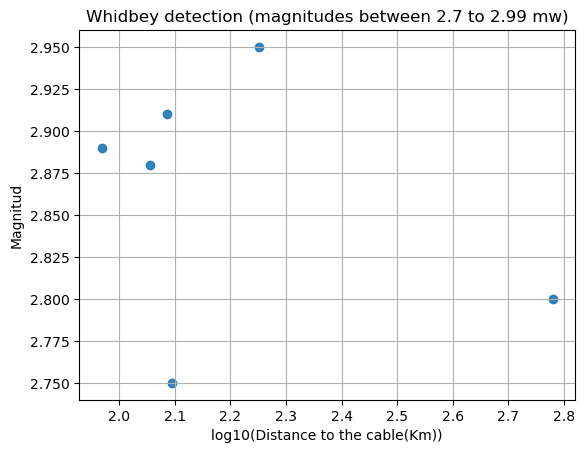

In [11]:
selected_rows = df[df.detect_das == 'TRUE']
plt.scatter(np.log10(selected_rows.Location),selected_rows.Magnitud,s=None, marker='o', alpha=0.9, label='Different earthquakes')
plt.xlabel('log10(Distance to the cable(Km))')
plt.ylabel('Magnitud')
plt.title('Whidbey detection (magnitudes between 2.7 to 2.99 mw)')
plt.grid()
plt.savefig("whidbeylocalquakes-lowmagnitud")
plt.show()
plt.close()

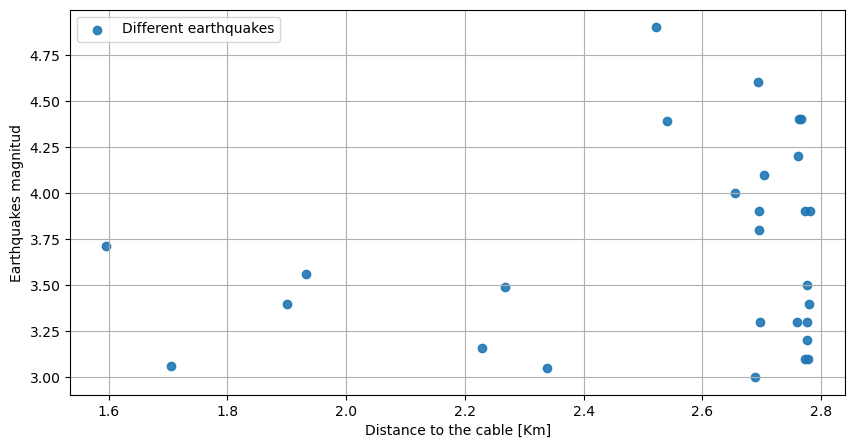

In [12]:
#creating plot distance vs magnitud
plt.subplots(figsize=(10,5))
plt.scatter(np.log10(dist_kmarray), magnituddarray,s=None, marker='o', alpha=0.9, label='Different earthquakes')
plt.xlabel('Distance to the cable [Km]')
plt.ylabel('Earthquakes magnitud');
plt.legend()
plt.grid()
plt.show()

# Data frame for earthquakes with WhibdeyCable

In [ ]:
#results for 
tf=['False','False','True','True','norecord','True','False','True','True','True','False','True','True','False','False','False','False','False','False','True','Norecord','Norecord','False','True','Norecord','Norecord','True','False']
tfn=np.array(tf).T
len(tf)
dataf = np.array([event_df.id, event_df.location, event_df.magnitude,tf],dtype='object').T
dataf

df3 = pd.DataFrame(dataf,columns=['Id', 'Distance', 'Magnitude','Detected by Das'])
df3



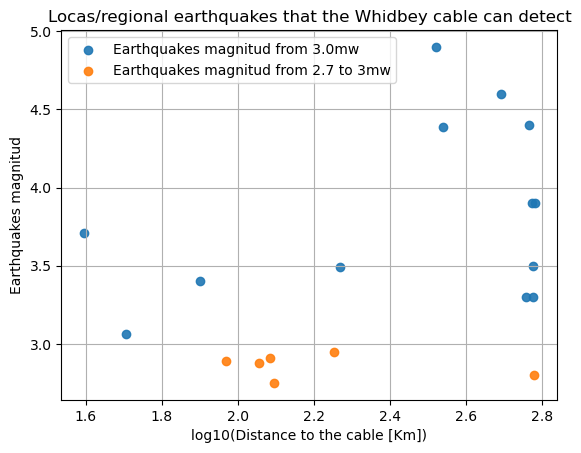

In [13]:
#creating plot distance vs magnitud (real earthquakes that we can see)
newmagtnitud=[magnituddarray[2],magnituddarray[3],magnituddarray[5],magnituddarray[7],magnituddarray[8],magnituddarray[10],magnituddarray[11],magnituddarray[13],magnituddarray[14],magnituddarray[18],magnituddarray[19],magnituddarray[23],magnituddarray[26]]
newdist_kmarray=[dist_kmarray[2],dist_kmarray[3],dist_kmarray[5],dist_kmarray[7],dist_kmarray[8],dist_kmarray[10],dist_kmarray[11],dist_kmarray[13],dist_kmarray[14],dist_kmarray[18],dist_kmarray[19],dist_kmarray[23],dist_kmarray[26]]
filename = f"earthquakes_distances600noseismogramswhidbey/"
figure=plt.plot(figsize=(10,5))
plt.scatter(np.log10(newdist_kmarray),newmagtnitud,s=None, marker='o', alpha=0.9, label='Earthquakes magnitud from 3.0mw')
plt.scatter(np.log10(selected_rows.Location),selected_rows.Magnitud,s=None, marker='o', alpha=0.9, label='Earthquakes magnitud from 2.7 to 3mw')
plt.title('Locas/regional earthquakes that the Whidbey cable can detect')
plt.xlabel('log10(Distance to the cable [Km])')
plt.ylabel('Earthquakes magnitud');
plt.legend()
plt.grid()
#plt.savefig(filename+"_whidbeylocalquakes")
plt.savefig("whidbeylocalquakes-27_to_50_mw")
plt.show()
plt.close()